- Генератор событий +  
- Дискритезатиция времени +  
- Оформить по красоте в класс

In [1]:
import msprime

In [2]:
from math import (exp, log)
import numpy as np

RHO_HUMAN = 1.6*10e-9
MU_HUMAN = 1.25*10e-8
RHO_LIMIT = (log(RHO_HUMAN)-100, log(RHO_HUMAN)+100)
MU_LIMIT = (log(MU_HUMAN)-100, log(MU_HUMAN)+100)

LENGTH_NORMALIZE_CONST = 4
ZIPPED = False
NUMBER_OF_EVENTS_LIMITS = (1, 20)
MAX_T_LIMITS = (0.01, 30)
LAMBDA_EXP = 1.0
POPULATION_LIMITS = (250, 100000)
POPULATION = 5000

N = 20

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)


def generate_demographic_events(popilation: int = POPULATION) -> list:
    """
    Generate demographic events.
    1) We generate number of events
    2) We choise time when events happens
    3) We choise how population has changed

    For more information learn msprime documentation


    Must return list of msprime.PopulationParametersChange objects
    https://msprime.readthedocs.io/en/stable/api.html#demographic-events
    """
    number_of_events = np.random.randint(
        low=NUMBER_OF_EVENTS_LIMITS[0], high=NUMBER_OF_EVENTS_LIMITS[1])
    max_t = np.random.uniform(low=MAX_T_LIMITS[0], high=MAX_T_LIMITS[1])

    times = sorted(np.random.exponential(LAMBDA_EXP, size=number_of_events))

    alpha = 1.0
    beta = np.log(max_t + 1)/times[-1]

    def to_exp_time(time: float) -> float:
        # time -> exponentional time
        return alpha*(np.exp(beta*time) - 1)

    exp_times = [to_exp_time(t) for t in times]
    # population_sizes = np.random.randint(
    #    low=POPULATION_LIMITS[0], high=POPULATION_LIMITS[1], size=number_of_events)

    population_sizes = np.random.beta(
        a=2, b=5, size=number_of_events)*popilation

    # init_population = np.random.randint(
    #    low=POPULATION_LIMITS[0], high=POPULATION_LIMITS[1])

    init_population = int(np.random.beta(a=2, b=5)*popilation)

    events = [msprime.PopulationParametersChange(
        0, initial_size=init_population, growth_rate=0)]

    for t, s in zip(exp_times, population_sizes):
        events.append(
            msprime.PopulationParametersChange(t, int(s), growth_rate=0)
        )
    return events


def give_rho() -> float:
    return exp(np.random.uniform(RHO_LIMIT[0], RHO_LIMIT[1]))


def give_mu() -> float:
    return exp(np.random.uniform(MU_LIMIT[0], MU_LIMIT[1]))

In [3]:
class arg:
    Ne = 1.0
    rho = 1.6*10e-9
    mu = 1.25*10e-8
    num_repl = 10 #int(1e5)
    l = 100000 #int(3e3)
    ratio_train_examples = 0.9
    random_seed = 42
    model = "hudson"
    sample_size = 2
    demographic_events = generate_demographic_events()

In [4]:
class Generator:
    def __init__(self, arg):
        self.arg = arg
        self.data_generator = msprime.simulate(
            sample_size=arg.sample_size,
            recombination_rate=arg.rho,
            mutation_rate=arg.mu,
            random_seed=arg.random_seed,
            model=arg.model,
            length=arg.l,
            num_replicates=arg.num_repl,
            demographic_events=arg.demographic_events
        )
        
        
    def __iter__(self):
        return self
    def __next__(self):
        try:
            replica = next(self.data_generator)
        except StopIteration:
            raise StopIteration
            
        haplotype = [0] * self.arg.l
        recombination_points = [0] * self.arg.l
        coal_times = [0] * self.arg.l
        
        # get mutations 
        for mutation in replica.mutations():
            point = round(mutation.position)
            if point < self.arg.l:
                haplotype[point] = 1
            else:
                haplotype[point - 1] = 1
                
        # get coal times and recombination points
        
        for tree in replica.trees():
            l,r = tree.get_interval()
            l,r = int(l), int(r)
            recombination_points[r - 1] = 1
            coal_times[l:r] = [tree.total_branch_length] * (r-l)
            
        # discrete times
        
        min_t, max_t = min(coal_times), max(coal_times)

        if max_t == min_t:
            min_t = 0.0000001 # Почти ноль

        a = (-np.log(max_t) + N*np.log(min_t))/(N-1)
        B = (-np.log(min_t) + np.log(max_t))/(N-1)

        def to_T(time):
            return round((np.log(time)-a)/B)
        
        d_times = [to_T(t) for t in coal_times]
        
        return haplotype, d_times, recombination_points

In [5]:
# To use
generator = Generator(arg)
i = next(generator)

In [12]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'genome')

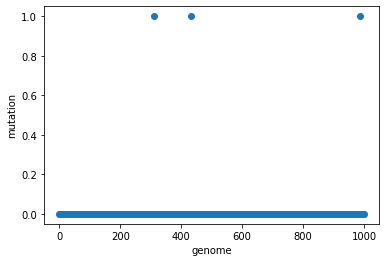

In [28]:
plt.scatter([x for x in range(len(i[0][:1000]))], i[0][:1000])
plt.ylabel('mutation')
plt.xlabel('genome')

Text(0.5, 0, 'genome')

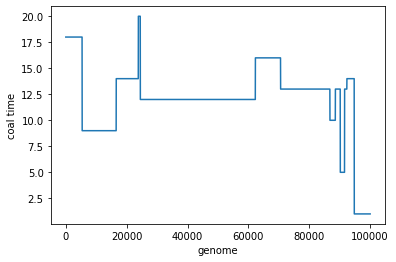

In [30]:
plt.plot([x for x in range(len(i[1]))], i[1])
plt.ylabel('coal time')
plt.xlabel('genome')